# Random Forest - Open-world Binary Scenario

**최적 Feature 조합**: 민 (8개 features)
- **성능**: Accuracy 98.36%, F1-Score 99.06%
- **시나리오**: Monitored vs Unmonitored 이진 분류

## Feature 구성
- **Basic Features**: 전송 시간
- **Cumulative Features**: 누적 패킷 수 (10%, 30%), 최대값
- **First 30 Features**: 첫 30개 패킷 특성 (4개)

이 조합은 가장 적은 feature로 가장 높은 성능을 달성했습니다.


## 1. 라이브러리 및 데이터 로드


In [1]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("라이브러리 로드 완료")


라이브러리 로드 완료


In [ ]:
# Load monitored features
MON_FILE_PATH = '../../../content/mon_features.pkl'
UNMON_FILE_PATH = '../../../content/unmon_features.pkl'

print("Monitored 데이터 로드 중...")
mon_features = pd.read_pickle(MON_FILE_PATH)
print(f"Monitored 데이터 형태: {mon_features.shape}")

# Load unmonitored features
print("\nUnmonitored 데이터 로드 중...")
unmon_features = pd.read_pickle(UNMON_FILE_PATH)
print(f"Unmonitored 데이터 형태: {unmon_features.shape}")
print("데이터 로드 완료!")


Monitored 데이터 로드 중...
Monitored 데이터 형태: (19000, 19)

Unmonitored 데이터 로드 및 처리 중...
Unmonitored 데이터 형태: (3000, 9)
데이터 로드 완료!


## 2. 최적 Feature 조합 정의 


In [3]:
# 민의 최적 feature 조합 (8개) - Open-world binary에서 최고 성능
selected_features = [
    'total_transmission_time', 
    'cumul_packets_10pct', 
    'cumul_packets_30pct',
    'cumul_max', 
    'num_incoming_first_30', 
    'outgoing_first_30',
    'avg_incoming_order_first_30', 
    'avg_outgoing_order_first_30'
]

print(f"선택된 Feature 수: {len(selected_features)}")
print("\nFeature 목록:")
for i, feature in enumerate(selected_features, 1):
    print(f"{i}. {feature}")

print("\nFeature 그룹별 구성:")
print("- Basic Features (1개): total_transmission_time")
print("- Cumulative Features (3개): cumul_packets_10pct, cumul_packets_30pct, cumul_max")
print("- First 30 Features (4개): num_incoming_first_30, outgoing_first_30, avg_incoming_order_first_30, avg_outgoing_order_first_30")


선택된 Feature 수: 8

Feature 목록:
1. total_transmission_time
2. cumul_packets_10pct
3. cumul_packets_30pct
4. cumul_max
5. num_incoming_first_30
6. outgoing_first_30
7. avg_incoming_order_first_30
8. avg_outgoing_order_first_30

Feature 그룹별 구성:
- Basic Features (1개): total_transmission_time
- Cumulative Features (3개): cumul_packets_10pct, cumul_packets_30pct, cumul_max
- First 30 Features (4개): num_incoming_first_30, outgoing_first_30, avg_incoming_order_first_30, avg_outgoing_order_first_30


## 3. 데이터 준비 (Binary Classification)


In [ ]:
# Open-world binary: monitored vs unmonitored 이진 분류
# Combine mon_features and unmon_features
features_df = pd.concat([mon_features, unmon_features], ignore_index=True)

X = features_df[selected_features]
y = features_df['monitored_label']

# Convert labels: -1 -> 0 (unmonitored), 1 -> 1 (monitored)
y = y.replace({-1: 0, 1: 1})

print(f"전체 샘플 수: {X.shape[0]}")
print(f"Feature 수: {X.shape[1]}")
print(f"Monitored 샘플: {sum(y == 1)} (클래스 1)")
print(f"Unmonitored 샘플: {sum(y == 0)} (클래스 0)")
print(f"클래스 비율: {sum(y == 1)/sum(y == 0):.1f}:1")

# 데이터 분할 (80% 훈련, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n훈련 데이터: {X_train.shape[0]} 샘플")
print(f"  - Monitored: {sum(y_train == 1)} 샘플")
print(f"  - Unmonitored: {sum(y_train == 0)} 샘플")
print(f"테스트 데이터: {X_test.shape[0]} 샘플")
print(f"  - Monitored: {sum(y_test == 1)} 샘플")
print(f"  - Unmonitored: {sum(y_test == 0)} 샘플")


전체 샘플 수: 22000
Feature 수: 8
Monitored 샘플: 19000 (클래스 1)
Unmonitored 샘플: 3000 (클래스 0)
클래스 비율: 6.3:1

훈련 데이터: 17600 샘플
  - Monitored: 15200 샘플
  - Unmonitored: 2400 샘플
테스트 데이터: 4400 샘플
  - Monitored: 3800 샘플
  - Unmonitored: 600 샘플


## 4. Random Forest 모델 훈련 및 평가


In [5]:
# 최적 하이퍼파라미터 (rf_analysis.ipynb 결과 기반)
best_params = {
    'bootstrap': True, 
    'max_depth': 20, 
    'max_features': 'log2', 
    'min_samples_leaf': 1, 
    'min_samples_split': 5, 
    'n_estimators': 100
}

print("최적 하이퍼파라미터:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

# Random Forest 모델 훈련
print("\nRandom Forest 모델 훈련 중...")
rf_clf = RandomForestClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)
print("모델 훈련 완료!")

# 예측
y_pred = rf_clf.predict(X_test)
y_pred_proba = rf_clf.predict_proba(X_test)

# 성능 지표 계산
accuracy = accuracy_score(y_test, y_pred)
f1_binary = f1_score(y_test, y_pred, average='binary')

print("\n" + "="*60)
print("OPEN-WORLD BINARY RANDOM FOREST 결과")
print("="*60)
print(f"정확도 (Accuracy): {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"F1-Score (Binary): {f1_binary:.4f}")
print("="*60)

# 상세 분류 리포트
print("\n분류 리포트:")
print(classification_report(y_test, y_pred, 
                          target_names=['Unmonitored', 'Monitored'],
                          digits=4))


최적 하이퍼파라미터:
  bootstrap: True
  max_depth: 20
  max_features: log2
  min_samples_leaf: 1
  min_samples_split: 5
  n_estimators: 100

Random Forest 모델 훈련 중...
모델 훈련 완료!

OPEN-WORLD BINARY RANDOM FOREST 결과
정확도 (Accuracy): 0.9836 (98.36%)
F1-Score (Binary): 0.9906

분류 리포트:
              precision    recall  f1-score   support

 Unmonitored     0.9648    0.9133    0.9384       600
   Monitored     0.9864    0.9947    0.9906      3800

    accuracy                         0.9836      4400
   macro avg     0.9756    0.9540    0.9645      4400
weighted avg     0.9835    0.9836    0.9834      4400



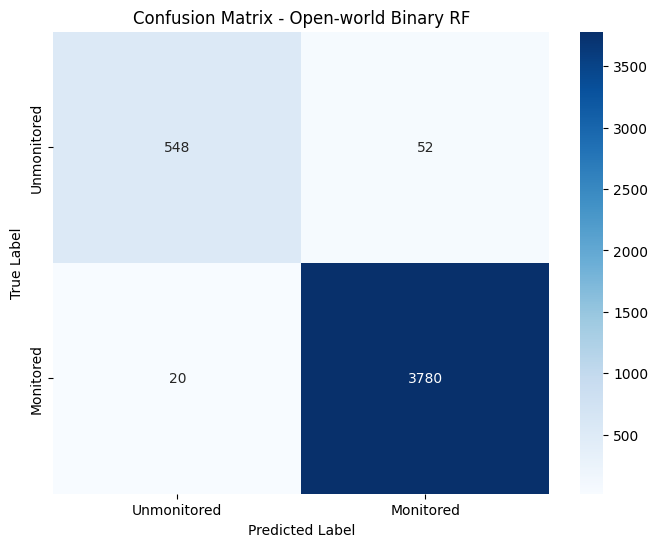


Feature 중요도:
                    feature  importance
                  cumul_max    0.450677
avg_incoming_order_first_30    0.104395
      num_incoming_first_30    0.084007
          outgoing_first_30    0.083633
        cumul_packets_30pct    0.077903
avg_outgoing_order_first_30    0.074552
        cumul_packets_10pct    0.071628
    total_transmission_time    0.053205


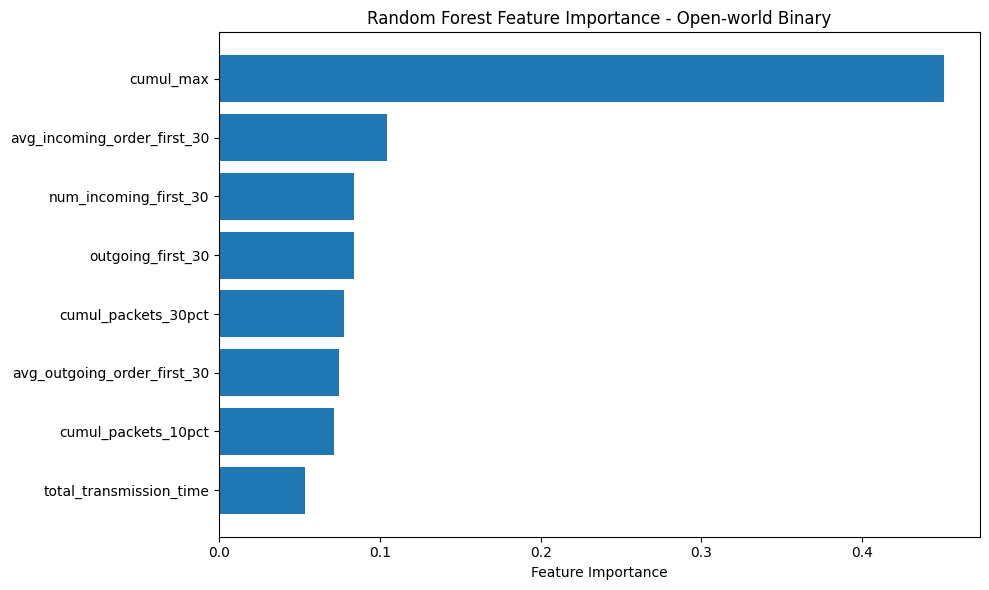

In [6]:
# Confusion Matrix 시각화
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Unmonitored', 'Monitored'],
            yticklabels=['Unmonitored', 'Monitored'])
plt.title('Confusion Matrix - Open-world Binary RF')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature 중요도 분석
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': rf_clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature 중요도:")
print(feature_importance.to_string(index=False))

# Feature 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance - Open-world Binary')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
